In [1]:
import requests
import json
import time
import zlib
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime
import time
import sys

In [2]:
url = "https://roboats.virtualregatta.com/api/"

def post_login() :
    
    r = requests.post(url+"login",
                  json={"email" : "malo.adler@telecom-paris.fr",
                            "password" : "wonderduck",
                            "raceId" : 531,
                            "legNum" : 1} )
    
    if(r.status_code != 200) :
        raise SystemExit("Login failed : " + str(r.status_code))
        
    return(r.headers['token'])

############################################################################################################################

def get_info_slow(token) :
    
    r = requests.get(url+"infos/slow",
                  headers={"token" : token })
    
    if(r.status_code != 200) :
        raise SystemExit("Get info slow failed : " + str(r.status_code))
        
    return(json.loads(r.text))

############################################################################################################################
def get_info_fast(token) :
    
    r = requests.get(url+"infos/fast",
                  headers={"token" : token })
    
    if(r.status_code != 200) :
        raise SystemExit("Get info fast failed : " + str(r.status_code))
        
    return(json.loads(r.text))

############################################################################################################################

def put_boat_action(token , json) :
    
    r = requests.put(url+"boat/actions",
                    headers={"token" : token },
                    json=json)
    
    if(r.status_code != 200) :
        raise SystemExit("Put boat action failed : " + str(r.status_code))

############################################################################################################################

def change_heading(token , deg , lock_sail) :
    
    if deg < 0 or deg > 360 :
        raise SystemExit("Degree should be between 0 and 360")
        
    json = {
        "tsLegStart": 1640010600000,
        "actions" : [
            {
                "type": "heading",
                "values" : {
                "deg": deg,
                "autoTwa": lock_sail
                }
            }
        ]
    }
    
    r = put_boat_action(token , json)

############################################################################################################################

def change_sail(token , sailId) :
    
    json = {
        "tsLegStart": 1640010600000,
        "actions" : [
            {
                "type": "sail",
                "values" : {
                    "sailId" : sailId
                }
            }
        ]
    }
    
    r = put_boat_action(token , json)
    
############################################################################################################################

def place_waypoint(token , wpid , lon , lat) :
    
    json = {
        "tsLegStart": 1640010600000,
        "actions" : [
            {
                "type": "wp",
                "values" : {
                    "nextWpIdx": wpid + 1,
                    "coordinates": [
                        {
                            "idx": wpid,
                            "pos" : {
                                "lon": lon,
                                "lat": lat
                            }
                        }
                    ]
                }
            }
        ]
    }
    
    r = put_boat_action(token , json)

In [3]:
token = post_login()
change_heading(token , 240 , False)
#change_sail(token , 10)
info_slow = get_info_slow(token)
info_fast = get_info_fast(token)
#place_waypoint(token , 1 , 48 , -7)
info_fast

{'rc': 'ok',
 'res': {'ba': [{'timestamp': 1654681800000,
    'type': 'heading',
    'values': {'deg': 240, 'autoTwa': False}}],
  'bs': {'aground': False,
   'badSail': False,
   'distanceFromStart': 5823.29795,
   'distanceToEnd': 3016.51294,
   'gateGroupCounters': [0],
   'hasPermanentAutoSails': True,
   'heading': 240,
   'icelimit': False,
   'isRegulated': False,
   'polar': 4,
   'pos': {'lat': 54.28323411527778, 'lon': -17.749200288214286},
   'rank': 0,
   'sail': 13,
   'speed': 7.17135,
   'stamina': None,
   'state': 'racing',
   'twa': 28.75925,
   'twaAuto': -90,
   'twd': 268.75925,
   'tws': 17.66206,
   'tsEndOfAutoSail': 1740407340000,
   'tsEndOfGybe': 0,
   'tsEndOfSailChange': 0,
   'tsEndOfTack': 0,
   'tsLastCalc': 1654681680000},
  'engine': {'tsLastCalc': 1654681680000, 'tsNextCalc': 1654681770000}}}

In [4]:
sail_type = {}
sail_type['Jib'] = 1
sail_type['Spi'] = 2
sail_type['Trinquette'] = 3
sail_type['Génois léger'] = 4
sail_type['Code 0'] = 5
sail_type['Spi lourd'] = 6
sail_type['Spi léger'] = 7
sail_type['Auto'] = 10


In [5]:
def get_info_boat(info_fast,info_slow) :
    
    infos = {}
    
    infos['lat'] = info_fast['res']['bs']['pos']['lat']
    infos['lon'] = info_fast['res']['bs']['pos']['lon']
    
    infos['cap'] = info_fast['res']['bs']['heading']
    
    infos['cap_wind'] = info_fast['res']['bs']['twa']
    
    infos['speed'] = info_fast['res']['bs']['speed']
    
    infos['sail'] = info_fast['res']['bs']['sail']
    
    infos['auto_sail'] = info_fast['res']['bs']['hasPermanentAutoSails']


    
    return(infos)

infos = get_info_boat(info_fast,info_slow)
infos

{'lat': 54.28323411527778,
 'lon': -17.749200288214286,
 'cap': 240,
 'cap_wind': 28.75925,
 'speed': 7.17135,
 'sail': 13,
 'auto_sail': True}

In [6]:

def get_url_carto(long,lat,res) :
    
    title_longitude = res*math.floor(long/res)
    title_latitude = res*math.ceil(lat/res)
    longitude_folder = str(int(title_longitude/10))
    latitude_folder = str(int(title_latitude/10))
    title = str(res) + '_' +  str(title_longitude) + '_' + str(title_latitude) + '.deg'
    
    url = 'https://static.virtualregatta.com/ressources/maps/dalles/vro2k16/' 
    url += str(res) + '/' + longitude_folder + '/' + latitude_folder + '/' 
    url += title
    return(url)

def get_carto(long,lat,res) :
    url = get_url_carto(long,lat,res)
    r = requests.get(url = url)
    with open('1_-4_44.deg','wb') as f :
        f.write(r.content)

    with open('1_-4_44.deg','rb') as f :
        header = f.read(11)
        gz = f.read()
        data = zlib.decompress(gz,-zlib.MAX_WBITS)

    data=np.frombuffer(data,dtype=np.int8)
    data.resize((730,730))
    return(data)


test = False
if(test) :
    res = 45
    n = 8
    m = 4
    d = np.zeros((730*m,730*n))
    plt.figure()
    plt.imshow(d)
    plt.show()

    for j in range(m) :
        for i in range(n):
            url = get_url_carto(-157 + i*res,67 - j*res,res)
            r = requests.get(url = url)
            print(url)
            with open('1_-4_44.deg','wb') as f :
                f.write(r.content)

            with open('1_-4_44.deg','rb') as f :
                header = f.read(11)
                gz = f.read()
                data = zlib.decompress(gz,-zlib.MAX_WBITS)

            data=np.frombuffer(data,dtype=np.int8)
            data.resize((730,730))
            d[730*j:730*(j+1):,730*i:730*(i+1)]  = data


            plt.imshow(d)
            plt.show()


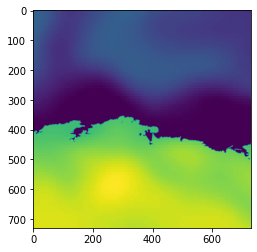

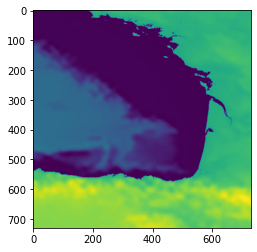

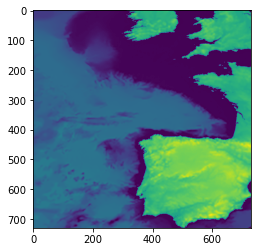

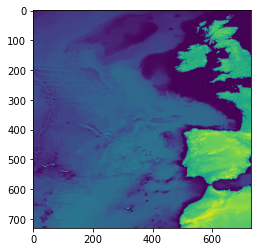

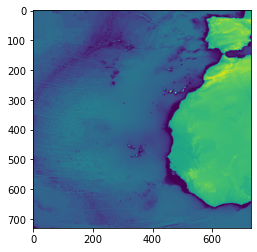

In [7]:
l = [1,6,18,30,45]

for i in l :
    m = get_carto(-4,44,i)
    plt.figure()
    plt.imshow(m)


In [16]:
def get_wind_info(year,month,day,hour,minute=0,second=0) :
    
    ti = datetime.datetime(year,month,day,hour,minute,second)
    
    r = requests.get(url = 'https://static.virtualregatta.com/winds/live/references.json')
    m = json.loads(r.text)
    
    t0 = datetime.datetime.fromtimestamp(m['references'][0][0]['valid_ts'])
    
    for i1 in range(len(m['references'])) :
        t1 = datetime.datetime.fromtimestamp(m['references'][i1][0]['valid_ts'])
        if t1 >= ti :
            break
        t0 = t1

    l0 = m['references'][i1-1][0]['rel_path']
    l1 = m['references'][i1][0]['rel_path']
    
    r = requests.get(url = 'https://static.virtualregatta.com/winds/' + l0 )
    with open('wind.wnd','wb') as f :
        f.write(r.content)
        
    wind_data0 = wind_parse()
    
    r = requests.get(url = 'https://static.virtualregatta.com/winds/' + l1 )
    with open('wind.wnd','wb') as f :
        f.write(r.content)
    
    wind_data1 = wind_parse()
    
    t02 = int(time.mktime(t0.timetuple()))
    t12 = int(time.mktime(t1.timetuple()))
    ti2 = int(time.mktime(ti.timetuple()))
    
    delta = t12-t02
    
    if delta == 0 :
        a = 1/2
    else :
        a = (ti2-t02)/delta
    
    wind_data = a*wind_data0 + (1-a)*wind_data1
    
    return(wind_data)
    
def wind_parse() :
    

    wind_data = np.zeros((360,181,2))

    lon = 0
    lat = 180
    
    with open('wind.wnd','rb') as f :
        
        byte = f.read(1)
        
        while byte :
            for i in [1,0] :
                byte = f.read(1)
                value = convert_byte_wind(byte)
                wind_data[lon,lat][i] = value

            lon += 1
            if lon == 360 :
                lat -= 1
                lon = 0
                
    return(wind_data)
            
            
        
def convert_byte_wind(byte) :
    value = int.from_bytes(byte, byteorder=sys.byteorder, signed=True)
    return(math.copysign(1,value) * ((value/8)**2))

In [9]:
r = requests.get(url = 'https://static.virtualregatta.com/winds/live/references.json')
m = json.loads(r.text)

t1 = datetime.datetime.fromtimestamp(m['references'][0][0]['avail_ts'])
for i in range(len(m['references'])) :
    print(datetime.datetime.fromtimestamp(m['references'][i][0]['valid_ts']))
    print(m['references'][i][0]['valid_time'])

2022-06-08 11:00:00
2022-06-08T09:00:00+00:00
2022-06-08 14:00:00
2022-06-08T12:00:00+00:00
2022-06-08 17:00:00
2022-06-08T15:00:00+00:00
2022-06-08 20:00:00
2022-06-08T18:00:00+00:00
2022-06-08 23:00:00
2022-06-08T21:00:00+00:00
2022-06-09 02:00:00
2022-06-09T00:00:00+00:00
2022-06-09 05:00:00
2022-06-09T03:00:00+00:00
2022-06-09 08:00:00
2022-06-09T06:00:00+00:00
2022-06-09 11:00:00
2022-06-09T09:00:00+00:00
2022-06-09 14:00:00
2022-06-09T12:00:00+00:00
2022-06-09 17:00:00
2022-06-09T15:00:00+00:00
2022-06-09 20:00:00
2022-06-09T18:00:00+00:00
2022-06-09 23:00:00
2022-06-09T21:00:00+00:00
2022-06-10 02:00:00
2022-06-10T00:00:00+00:00
2022-06-10 05:00:00
2022-06-10T03:00:00+00:00
2022-06-10 08:00:00
2022-06-10T06:00:00+00:00
2022-06-10 11:00:00
2022-06-10T09:00:00+00:00
2022-06-10 14:00:00
2022-06-10T12:00:00+00:00
2022-06-10 17:00:00
2022-06-10T15:00:00+00:00
2022-06-10 20:00:00
2022-06-10T18:00:00+00:00
2022-06-10 23:00:00
2022-06-10T21:00:00+00:00
2022-06-11 02:00:00
2022-06-11T00:

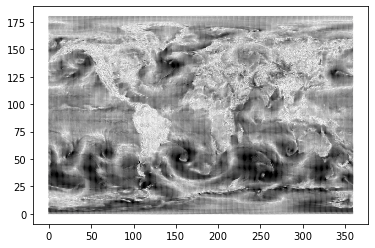

In [20]:
wind_data = get_wind_info(2022,6,8,12,minute=30,second=0)

plt.figure()
for i in range(len(wind_data)) :
    for j in range(len(wind_data[0])) :
        plt.arrow(i,j,wind_data[i][j][0]/100,wind_data[i][j][1]/100)
